In [ ]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


In [ ]:
import gdown
!gdown --fuzzy https://drive.google.com/file/d/1wEc5liKTpiTnugwqKqIXy4qzcrV0eRpG/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1wEc5liKTpiTnugwqKqIXy4qzcrV0eRpG
From (redirected): https://drive.usercontent.google.com/download?id=1wEc5liKTpiTnugwqKqIXy4qzcrV0eRpG&confirm=t&uuid=d9d5a5be-82bf-4d7a-aeb3-938e6c99ed47
To: /content/archive (3).zip
100% 693M/693M [00:13<00:00, 52.0MB/s]


In [ ]:
import gdown
!gdown --fuzzy https://drive.google.com/file/d/1HuCXt44cuprBbz9z3rl3TxnXAfM_wMPG/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1HuCXt44cuprBbz9z3rl3TxnXAfM_wMPG
From (redirected): https://drive.usercontent.google.com/download?id=1HuCXt44cuprBbz9z3rl3TxnXAfM_wMPG&confirm=t&uuid=addca5d3-4f39-4cf8-954a-2d06e6b152ba
To: /content/rec2023.zip
100% 1.93G/1.93G [00:29<00:00, 64.4MB/s]


In [ ]:
!unzip /content/archive.zip

unzip:  cannot find or open /content/archive.zip, /content/archive.zip.zip or /content/archive.zip.ZIP.


In [ ]:
!unzip /content/rec2023.zip

Archive:  /content/rec2023.zip
  inflating: anime-dataset-2023.csv  
  inflating: anime-filtered.csv      
  inflating: final_animedataset.csv  
  inflating: user-filtered.csv       
  inflating: users-details-2023.csv  
  inflating: users-score-2023.csv    


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud
from collections import defaultdict
from collections import Counter

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
df=pd.read_csv('/content/users-score-2023.csv', usecols=["user_id","anime_id","rating"])
print("Shape of the Dataset:",df.shape)
df.head()

Shape of the Dataset: (24325191, 3)


,user_id,anime_id,rating
0,1,21,9
1,1,48,7
2,1,320,5
3,1,49,8
4,1,304,8


In [ ]:
duplicated_rows = df[df.duplicated()]
print("Duplicated Rows:")
print(duplicated_rows)

Duplicated Rows:
Empty DataFrame
Columns: [user_id, anime_id, rating]
Index: []


In [ ]:
avg_score = np.mean(df['rating'])
print('Average Score:', avg_score)

Average Score: 7.622930072779285


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the 'score' column between 0 and 1
df['scaled_score'] = scaler.fit_transform(df[['rating']])

In [ ]:
# Encoding categorical data

## Encoding user IDs
user_encoder = LabelEncoder()
df["user_encoded"] = user_encoder.fit_transform(df["user_id"])
num_users = len(user_encoder.classes_)

## Encoding anime IDs
anime_encoder = LabelEncoder()
df["anime_encoded"] = anime_encoder.fit_transform(df["anime_id"])
num_animes = len(anime_encoder.classes_)

# Printing dataset information
print("Number of unique users: {}, Number of unique anime: {}".format(num_users, num_animes))
print("Minimum rating: {}, Maximum rating: {}".format(min(df['rating']), max(df['rating'])))

Number of unique users: 270033, Number of unique anime: 16500
Minimum rating: 1, Maximum rating: 10


##collaborative filtering

In [ ]:
# Shuffle the dataset
df = shuffle(df, random_state=100)

# Create feature matrix X and target variable y
X = df[['user_encoded', 'anime_encoded']].values
y = df["scaled_score"].values

# Printing dataset information
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (24325191, 2)
Shape of y: (24325191,)


In [ ]:
test_set_size = 10000  # Number of samples to include in the test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=73)

print("Number of samples in the training set:", len(y_train))
print("Number of samples in the test set:", len(y_test))

Number of samples in the training set: 24315191
Number of samples in the test set: 10000


In [ ]:
# Prepare input data for model training and evaluation
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [ ]:
def RecommenderNet(num_users, num_animes, embedding_size=128):
    # User input layer and embedding layer
    user = Input(name='user_encoded', shape=[1])
    user_embedding = Embedding(name='user_embedding', input_dim=num_users, output_dim=embedding_size)(user)

    # Anime input layer and embedding layer
    anime = Input(name='anime_encoded', shape=[1])
    anime_embedding = Embedding(name='anime_embedding', input_dim=num_animes, output_dim=embedding_size)(anime)

    # Dot product of user and anime embeddings
    dot_product = Dot(name='dot_product', normalize=True, axes=2)([user_embedding, anime_embedding])
    flattened = Flatten()(dot_product)

    # Dense layers for prediction
    dense = Dense(64, activation='relu')(flattened)
    output = Dense(1, activation='sigmoid')(dense)

    # Create and compile the model
    model = Model(inputs=[user, anime], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=["mae", "mse"])

    return model

In [ ]:
model = RecommenderNet(num_users, num_animes)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_encoded (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 anime_encoded (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 128)               3456422   ['user_encoded[0][0]']        
                                                          4                                       
                                                                                                  
 anime_embedding (Embedding  (None, 1, 128)               2112000   ['anime_encoded[0][0]']   

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

In [ ]:
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

In [ ]:
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

In [ ]:
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

In [ ]:
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

In [ ]:
checkpoint_filepath = 'myanimeweights.h5'

In [ ]:
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

In [ ]:
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)


In [ ]:
my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping
]

In [ ]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

Epoch 1/20
2432/2432 [==============================] - 91s 33ms/step - loss: 0.6775 - mae: 0.2494 - mse: 0.0819 - val_loss: 0.6586 - val_mae: 0.2309 - val_mse: 0.0721 - lr: 1.0000e-05
Epoch 2/20
2432/2432 [==============================] - 47s 19ms/step - loss: 0.6277 - mae: 0.2018 - mse: 0.0573 - val_loss: 0.6010 - val_mae: 0.1739 - val_mse: 0.0442 - lr: 1.8000e-05
Epoch 3/20
2432/2432 [==============================] - 45s 19ms/step - loss: 0.5843 - mae: 0.1542 - mse: 0.0371 - val_loss: 0.5771 - val_mae: 0.1468 - val_mse: 0.0336 - lr: 2.6000e-05
Epoch 4/20
2432/2432 [==============================] - 43s 18ms/step - loss: 0.5759 - mae: 0.1445 - mse: 0.0335 - val_loss: 0.5747 - val_mae: 0.1421 - val_mse: 0.0327 - lr: 3.4000e-05
Epoch 5/20
2432/2432 [==============================] - 50s 20ms/step - loss: 0.5627 - mae: 0.1304 - mse: 0.0285 - val_loss: 0.5591 - val_mae: 0.1264 - val_mse: 0.0268 - lr: 4.2000e-05
Epoch 6/20
2432/2432 [==============================] - 48s 20ms/step - los

In [ ]:
model.load_weights(checkpoint_filepath)

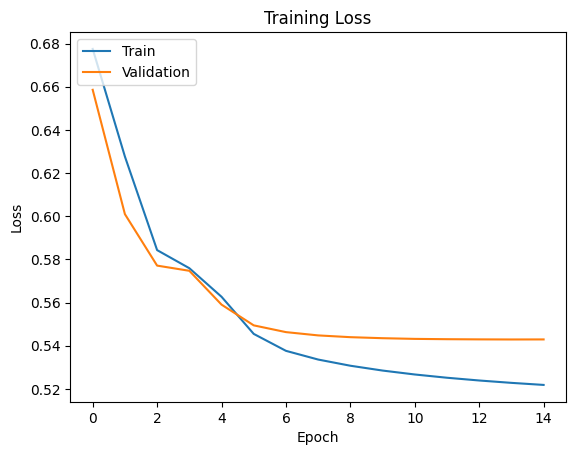

In [ ]:
plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [ ]:
def extract_weights(name, model):
    # Get the layer by name from the model
    weight_layer = model.get_layer(name)

    # Get the weights from the layer
    weights = weight_layer.get_weights()[0]

    # Normalize the weights
    weights = weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))

    return weights

# Extract weights for anime embeddings
anime_weights = extract_weights('anime_embedding', model)
# Extract weights for user embeddings
user_weights = extract_weights('user_embedding', model)

In [ ]:
np.save('animeweights.npy', anime_weights)
np.save('userweights.npy', user_weights)

In [ ]:
df_anime=pd.read_csv('/content/anime-dataset-2023.csv')

Now I want my model to recommend only those animes that have been rated by at least a certain number of users, which I will set as the threshold. This threshold helps ensure that the recommended anime titles have received a sufficient number of ratings, indicating a certain level of popularity or user engagement.

In [ ]:
popularity_threshold = 50
df_anime= df_anime.query('Members >= @popularity_threshold')
print(df_anime.shape)
df_anime.head(3)

(22879, 24)


,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...


##Item Based Recommendation

In [ ]:
def find_similar_animes(name, n=10, return_dist=False, neg=False):
    try:
        anime_row = df_anime[df_anime['Name'] == name].iloc[0]
        index = anime_row['anime_id']
        encoded_index = anime_encoder.transform([index])[0]
        weights = anime_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n = n + 1
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
        print('Animes closest to {}'.format(name))
        if return_dist:
            return dists, closest

        SimilarityArr = []

        for close in closest:
            decoded_id = anime_encoder.inverse_transform([close])[0]
            anime_frame = df_anime[df_anime['anime_id'] == decoded_id]

            anime_name = anime_frame['Name'].values[0]
            english_name = anime_frame['English name'].values[0]
            name = english_name if english_name != "UNKNOWN" else anime_name
            genre = anime_frame['Genres'].values[0]
            Synopsis = anime_frame['Synopsis'].values[0]
            similarity = dists[close]
            similarity = "{:.2f}%".format(similarity * 100)
            SimilarityArr.append({"Name": name, "Similarity": similarity, "Genres": genre, "Synopsis":Synopsis})
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="Similarity", ascending=False)
        return Frame[Frame.Name != name]
    except:
        print('{} not found in Anime list'.format(name))

pd.set_option('display.max_colwidth', None)


In [ ]:
find_similar_animes('Tensei shitara Slime Datta Ken', n=5, neg=False)# that is That Time I Got Reincarnated as a Slime

Animes closest to Tensei shitara Slime Datta Ken


,Name,Similarity,Genres,Synopsis
4,That Time I Got Reincarnated as a Slime Season 2,83.46%,"Action, Adventure, Comedy, Fantasy","Taking a break from his time as a teacher, the powerful slime Rimuru Tempest returns to his kingdom, eponymously named Tempest, just in time to begin negotiations with a nearby nation—the Kingdom of Eurazania. While the negotiations are anything but peaceful, they do end successfully, allowing Rimuru to return and finish teaching. When trying to again return to Tempest, this time permanently, Rimuru is stopped by a mysterious figure who is somehow able to constrain the many magical abilities he has at his disposal. \n\nIn Tempest, the situation is even worse. A group of unknown humans has invaded the land and are assaulting its citizens, both influential and innocent. They are not just trying to bring harm either—they have the intent to kill. Can Rimuru overcome his powerful and dangerous foe and return to Tempest before it is too late?"
3,Demon Slayer: Kimetsu no Yaiba,78.49%,"Action, Award Winning, Fantasy","Ever since the death of his father, the burden of supporting the family has fallen upon Tanjirou Kamado's shoulders. Though living impoverished on a remote mountain, the Kamado family are able to enjoy a relatively peaceful and happy life. One day, Tanjirou decides to go down to the local village to make a little money selling charcoal. On his way back, night falls, forcing Tanjirou to take shelter in the house of a strange man, who warns him of the existence of flesh-eating demons that lurk in the woods at night.\n\nWhen he finally arrives back home the next day, he is met with a horrifying sight—his whole family has been slaughtered. Worse still, the sole survivor is his sister Nezuko, who has been turned into a bloodthirsty demon. Consumed by rage and hatred, Tanjirou swears to avenge his family and stay by his only remaining sibling. Alongside the mysterious group calling themselves the Demon Slayer Corps, Tanjirou will do whatever it takes to slay the demons and protect the remnants of his beloved sister's humanity."
2,That Time I Got Reincarnated as a Slime Season 2 Part 2,77.52%,"Action, Adventure, Comedy, Fantasy","The nation of Tempest is in a festive mood after successfully overcoming the surprise attack from the Falmuth Army and the Western Holy Church. Beyond the festivities lies a meeting between Tempest and its allies to decide the future of the Nation of Monsters. The aftermath of the Falmuth invasion, Milim Nava's suspicious behavior, and the disappearance of Demon Lord Carrion—the problems seem to keep on piling up.\n\nRimuru Tempest, now awakened as a ""True Demon Lord,"" decides to go on the offensive against Clayman. With the fully revived ""Storm Dragon"" Veldora, ""Ultimate Skill"" Raphael, and other powerful comrades, the ruler of the Tempest is confident in taking down his enemies one by one until he can face the man pulling the strings."
1,My Hero Academia Season 3,74.43%,Action,"As summer arrives for the students at UA Academy, each of these superheroes-in-training puts in their best efforts to become renowned heroes. They head off to a forest training camp run by UA's pro heroes, where the students face one another in battle and go through dangerous tests, improving their abilities and pushing past their limits. However, their school trip is suddenly turned upside down when the League of Villains arrives, invading the camp with a mission to capture one of the students. \n\nBoku no Hero Academia 3rd Season follows Izuku ""Deku"" Midoriya, an ambitious student training to achieve his dream of becoming a hero similar to his role model—All Might. Being one of the students caught up amidst the chaos of the villain attack, Deku must take a stand with his classmates and fight for their survival."
0,The Rising of the Shield Hero,74.02%,"Action, Adventure, Drama, Fantasy","The Four Cardinal Heroes are a group of ordinary men from modern-day Japan summoned to the kingdom of Mel

In [ ]:
find_similar_animes('Shigatsu wa Kimi no Uso', n=5, neg=False) # Your Lie in April

Animes closest to Shigatsu wa Kimi no Uso


,Name,Similarity,Genres,Synopsis
4,ERASED,88.26%,"Mystery, Supernatural, Suspense","When tragedy is about to strike, Satoru Fujinuma finds himself sent back several minutes before the accident occurs. The detached, 29-year-old manga artist has taken advantage of this powerful yet mysterious phenomenon, which he calls ""Revival,"" to save many lives.\n \nHowever, when he is wrongfully accused of murdering someone close to him, Satoru is sent back to the past once again, but this time to 1988, 18 years in the past. Soon, he realizes that the murder may be connected to the abduction and killing of one of his classmates, the solitary and mysterious Kayo Hinazuki, that took place when he was a child. This is his chance to make things right.\n \nBoku dake ga Inai Machi follows Satoru in his mission to uncover what truly transpired 18 years ago and prevent the death of his classmate while protecting those he cares about in the present."
3,Your Name.,87.39%,"Award Winning, Drama, Supernatural","Mitsuha Miyamizu, a high school girl, yearns to live the life of a boy in the bustling city of Tokyo—a dream that stands in stark contrast to her present life in the countryside. Meanwhile in the city, Taki Tachibana lives a busy life as a high school student while juggling his part-time job and hopes for a future in architecture.\n\nOne day, Mitsuha awakens in a room that is not her own and suddenly finds herself living the dream life in Tokyo—but in Taki's body! Elsewhere, Taki finds himself living Mitsuha's life in the humble countryside. In pursuit of an answer to this strange phenomenon, they begin to search for one another.\n\nKimi no Na wa. revolves around Mitsuha and Taki's actions, which begin to have a dramatic impact on each other's lives, weaving them into a fabric held together by fate and circumstance."
2,A Silent Voice,86.36%,"Award Winning, Drama","As a wild youth, elementary school student Shouya Ishida sought to beat boredom in the cruelest ways. When the deaf Shouko Nishimiya transfers into his class, Shouya and the rest of his class thoughtlessly bully her for fun. However, when her mother notifies the school, he is singled out and blamed for everything done to her. With Shouko transferring out of the school, Shouya is left at the mercy of his classmates. He is heartlessly ostracized all throughout elementary and middle school, while teachers turn a blind eye.\n\nNow in his third year of high school, Shouya is still plagued by his wrongdoings as a young boy. Sincerely regretting his past actions, he sets out on a journey of redemption: to meet Shouko once more and make amends.\n\nKoe no Katachi tells the heartwarming tale of Shouya's reunion with Shouko and his honest attempts to redeem himself, all while being continually haunted by the shadows of his past."
1,Anohana: The Flower We Saw That Day,83.62%,"Drama, Supernatural","Jinta Yadomi is peacefully living as a recluse, spending his days away from school and playing video games at home instead. One hot summer day, his childhood friend, Meiko ""Menma"" Honma, appears and pesters him to grant a forgotten wish. He pays her no mind, which annoys her, but he doesn't really care. After all, Menma already died years ago.\n\nAt first, Jinta thinks that he is merely hallucinating due to the summer heat, but he is later on convinced that what he sees truly is the ghost of Menma. Jinta and his group of childhood friends grew apart after her untimely death, but they are drawn together once more as they try to lay Menma's spirit to rest. Re-living their pain and guilt, will they be able to find the strength to help not only Menma move on—but themselves as well?"
0,One Punch Man,83.22%,"Action, Comedy","The seemingly unimpressive Saitama has a rather unique hobby: being a hero. In order to pursue his childhood dream, Saitama relentlessly trained for three years, losing all of his hair in the process. Now, Saitama is so powerful, he can defeat any enemy with just one punch. However, hav

In [ ]:
find_similar_animes('One Punch Man', n=5, neg=False)

Animes closest to One Punch Man


,Name,Similarity,Genres,Synopsis
3,Your Name.,86.02%,"Award Winning, Drama, Supernatural","Mitsuha Miyamizu, a high school girl, yearns to live the life of a boy in the bustling city of Tokyo—a dream that stands in stark contrast to her present life in the countryside. Meanwhile in the city, Taki Tachibana lives a busy life as a high school student while juggling his part-time job and hopes for a future in architecture.\n\nOne day, Mitsuha awakens in a room that is not her own and suddenly finds herself living the dream life in Tokyo—but in Taki's body! Elsewhere, Taki finds himself living Mitsuha's life in the humble countryside. In pursuit of an answer to this strange phenomenon, they begin to search for one another.\n\nKimi no Na wa. revolves around Mitsuha and Taki's actions, which begin to have a dramatic impact on each other's lives, weaving them into a fabric held together by fate and circumstance."
4,Hunter x Hunter,86.02%,"Action, Adventure, Fantasy","Hunters devote themselves to accomplishing hazardous tasks, all from traversing the world's uncharted territories to locating rare items and monsters. Before becoming a Hunter, one must pass the Hunter Examination—a high-risk selection process in which most applicants end up handicapped or worse, deceased.\n\nAmbitious participants who challenge the notorious exam carry their own reason. What drives 12-year-old Gon Freecss is finding Ging, his father and a Hunter himself. Believing that he will meet his father by becoming a Hunter, Gon takes the first step to walk the same path.\n\nDuring the Hunter Examination, Gon befriends the medical student Leorio Paladiknight, the vindictive Kurapika, and ex-assassin Killua Zoldyck. While their motives vastly differ from each other, they band together for a common goal and begin to venture into a perilous world."
2,Made in Abyss,85.75%,"Adventure, Drama, Fantasy, Mystery, Sci-Fi","The Abyss—a gaping chasm stretching down into the depths of the earth, filled with mysterious creatures and relics from a time long past. How did it come to be? What lies at the bottom? Countless brave individuals, known as Divers, have sought to solve these mysteries of the Abyss, fearlessly descending into its darkest realms. The best and bravest of the Divers, the White Whistles, are hailed as legends by those who remain on the surface.\n\nRiko, daughter of the missing White Whistle Lyza the Annihilator, aspires to become like her mother and explore the furthest reaches of the Abyss. However, just a novice Red Whistle herself, she is only permitted to roam its most upper layer. Even so, Riko has a chance encounter with a mysterious robot with the appearance of an ordinary young boy. She comes to name him Reg, and he has no recollection of the events preceding his discovery. Certain that the technology to create Reg must come from deep within the Abyss, the two decide to venture forth into the chasm to recover his memories and see the bottom of the great pit with their own eyes. However, they know not of the harsh reality that is the true existence of the Abyss."
1,Demon Slayer: Kimetsu no Yaiba,85.28%,"Action, Award Winning, Fantasy","Ever since the death of his father, the burden of supporting the family has fallen upon Tanjirou Kamado's shoulders. Though living impoverished on a remote mountain, the Kamado family are able to enjoy a relatively peaceful and happy life. One day, Tanjirou decides to go down to the local village to make a little money selling charcoal. On his way back, night falls, forcing Tanjirou to take shelter in the house of a strange man, who warns him of the existence of flesh-eating demons that lurk in the woods at night.\n\nWhen he finally arrives back home the next day, he is met with a horrifying sight—his whole family has been slaughtered. Worse still, the sole survivor is his sister Nezuko, who has been turned into a bloodthirsty demon. Consumed by rage and hatred, Tanjirou swears to avenge his family and stay by his only re

In [ ]:
find_similar_animes('Mushoku Tensei: Isekai Ittara Honki Dasu', n=5, neg=False)

Animes closest to Mushoku Tensei: Isekai Ittara Honki Dasu


,Name,Similarity,Genres,Synopsis
4,Mushoku Tensei: Jobless Reincarnation Part 2,89.32%,"Drama, Fantasy, Ecchi","After the mysterious mana calamity, Rudeus Greyrat and his fierce student Eris Boreas Greyrat are teleported to the Demon Continent. There, they team up with their newfound companion Ruijerd Supardia—the former leader of the Superd's Warrior group—to form ""Dead End,"" a successful adventurer party. Making a name for themselves, the trio journeys across the continent to make their way back home to Fittoa.\n\nFollowing the advice he received from the faceless god Hitogami, Rudeus saves Kishirika Kishirisu, the Great Emperor of the Demon World, who rewards him by granting him a strange power. Now, as Rudeus masters the powerful ability that offers a number of new opportunities, it might prove to be more than what he bargained for when unexpected dangers threaten to hinder their travels."
3,Made in Abyss,71.95%,"Adventure, Drama, Fantasy, Mystery, Sci-Fi","The Abyss—a gaping chasm stretching down into the depths of the earth, filled with mysterious creatures and relics from a time long past. How did it come to be? What lies at the bottom? Countless brave individuals, known as Divers, have sought to solve these mysteries of the Abyss, fearlessly descending into its darkest realms. The best and bravest of the Divers, the White Whistles, are hailed as legends by those who remain on the surface.\n\nRiko, daughter of the missing White Whistle Lyza the Annihilator, aspires to become like her mother and explore the furthest reaches of the Abyss. However, just a novice Red Whistle herself, she is only permitted to roam its most upper layer. Even so, Riko has a chance encounter with a mysterious robot with the appearance of an ordinary young boy. She comes to name him Reg, and he has no recollection of the events preceding his discovery. Certain that the technology to create Reg must come from deep within the Abyss, the two decide to venture forth into the chasm to recover his memories and see the bottom of the great pit with their own eyes. However, they know not of the harsh reality that is the true existence of the Abyss."
2,Demon Slayer: Kimetsu no Yaiba,71.63%,"Action, Award Winning, Fantasy","Ever since the death of his father, the burden of supporting the family has fallen upon Tanjirou Kamado's shoulders. Though living impoverished on a remote mountain, the Kamado family are able to enjoy a relatively peaceful and happy life. One day, Tanjirou decides to go down to the local village to make a little money selling charcoal. On his way back, night falls, forcing Tanjirou to take shelter in the house of a strange man, who warns him of the existence of flesh-eating demons that lurk in the woods at night.\n\nWhen he finally arrives back home the next day, he is met with a horrifying sight—his whole family has been slaughtered. Worse still, the sole survivor is his sister Nezuko, who has been turned into a bloodthirsty demon. Consumed by rage and hatred, Tanjirou swears to avenge his family and stay by his only remaining sibling. Alongside the mysterious group calling themselves the Demon Slayer Corps, Tanjirou will do whatever it takes to slay the demons and protect the remnants of his beloved sister's humanity."
1,A Silent Voice,71.59%,"Award Winning, Drama","As a wild youth, elementary school student Shouya Ishida sought to beat boredom in the cruelest ways. When the deaf Shouko Nishimiya transfers into his class, Shouya and the rest of his class thoughtlessly bully her for fun. However, when her mother notifies the school, he is singled out and blamed for everything done to her. With Shouko transferring out of the school, Shouya is left at the mercy of his classmates. He is heartlessly ostracized all throughout elementary and middle school, while teachers turn a blind eye.\n\nNow in his third year of high school, Shouya is still plagued by his wrongdoings as a young boy. Sincerely regretting his past actions, he sets out o

##User Based Recommendation

#**part** 1-Finding Similar Users

In [ ]:
def find_similar_users(item_input, n=10, return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user_encoder.transform([index])[0]
        weights = user_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n = n + 1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        SimilarityArr = []

        for close in closest:
            similarity = dists[close]
            if isinstance(item_input, int):
                decoded_id = user_encoder.inverse_transform([close])[0]
                SimilarityArr.append({"similar_users": decoded_id, "similarity": similarity})
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame
    except:
        print('\033[1m{}\033[0m, Not Found in User list'.format(item_input))

In [ ]:
ratings_per_user = df.groupby('user_id').size()
random_user = int(ratings_per_user[ratings_per_user < 500].sample(1, random_state=None).index[0])

# Find similar users to the random user
similar_users = find_similar_users(random_user, n=10, neg=False)
similar_users = similar_users[similar_users.similarity > 0.4]
similar_users = similar_users[similar_users.similar_users != random_user]
similar_users

,similar_users,similarity
9,1102017,0.517511
8,1072121,0.494294
7,1125903,0.483355
6,84228,0.473778
5,1077273,0.473598
4,754995,0.473049
3,383710,0.472671
2,798231,0.472543
1,344767,0.470006
0,507743,0.466156


#Part 2: User Preferences

In [ ]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10, 8))
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def get_user_preferences(user_id, plot=False, verbose=0):
    animes_watched_by_user = df[df['user_id'] == user_id]

    if animes_watched_by_user.empty:
        print("User #{} has not watched any animes.".format(user_id))
        return pd.DataFrame()

    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]
    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False)
        .anime_id.values
    )

    anime_df_rows = df_anime[df_anime["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["Name", "Genres"]]

    if verbose != 0:
        print("User \033[1m{}\033[0m has watched {} anime(s) with an average rating of {:.1f}/10\n".format(
            user_id, len(animes_watched_by_user), animes_watched_by_user['rating'].mean()
        ))
        print('\033[1m----- Preferred genres----- \033[0m\n')

    if plot:
        genres_list = []
        for genres in anime_df_rows['Genres']:
            if isinstance(genres, str):
                for genre in genres.split(','):
                    genres_list.append(genre.strip())

        showWordCloud(dict(Counter(genres_list)))

    return anime_df_rows


User 559971 has watched 25 anime(s) with an average rating of 10.0/10

----- Preferred genres----- 



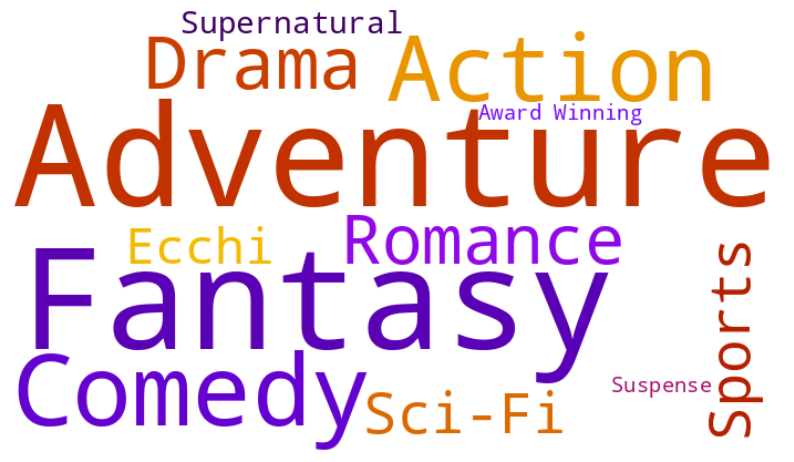

,Name,Genres
10,Naruto,"Action, Adventure, Fantasy"
100,Fullmetal Alchemist,"Action, Adventure, Award Winning, Drama, Fantasy"
264,Bakuten Shoot Beyblade,"Action, Adventure, Comedy, Sports"
328,Motto! Ojamajo Doremi,"Comedy, Fantasy"
329,Ojamajo Doremi Dokkaan!,"Comedy, Fantasy"


In [ ]:
user_pref = get_user_preferences(random_user, plot=True, verbose=1)
pd.DataFrame(user_pref).head(5)

#Part 3: Recommending Animes for a User

In [ ]:
def get_recommended_animes(similar_users, user_pref, n=10):
    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id))
        if not pref_list.empty:  # Check if user has watched any animes
            pref_list = pref_list[~pref_list["Name"].isin(user_pref["Name"].values)]
            anime_list.append(pref_list.Name.values)

    if len(anime_list) == 0:
        print("No anime recommendations available for the given users.")
        return pd.DataFrame()

    anime_list = pd.DataFrame(anime_list)
    sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)
    # Count the occurrences of each anime in the entire dataset
    anime_count = df['anime_id'].value_counts()

    for i, anime_name in enumerate(sorted_list.index):
        if isinstance(anime_name, str):
            try:
                anime_id = df_anime[df_anime.Name == anime_name].anime_id.values[0]
                english_name = df_anime[df_anime['Name'] == anime_name]['English name'].values[0]
                name = english_name if english_name != "UNKNOWN" else anime_name
                genre = df_anime[df_anime.Name == anime_name].Genres.values[0]
                Synopsis = df_anime[df_anime.Name == anime_name].Synopsis.values[0]
                n_user_pref = anime_count.get(anime_id, 0)  # Get the total count of users who have watched this anime
                recommended_animes.append({
                    "n": n_user_pref,
                    "anime_name": anime_name,
                    "Genres": genre,
                    "Synopsis": Synopsis
                })
            except:
                pass
    return pd.DataFrame(recommended_animes)

In [ ]:
recommended_animes = get_recommended_animes(similar_users, user_pref, n=10)

print('\n> Top recommendations for user: {}'.format(random_user))
recommended_animes


> Top recommendations for user: 559971


,n,anime_name,Genres,Synopsis
0,24039,Accel World,"Action, Romance, Sci-Fi","Haruyuki Arita is an overweight, bullied middle schooler who finds solace in playing online games. But his life takes a drastic turn one day, when he finds that all his high scores have been topped by Kuroyukihime, the popular vice president of the student council. She then invites him to the student lounge and introduces him to ""Brain Burst,"" a program which allows the users to accelerate their brain waves to the point where time seems to stop. Brain Burst also functions as an augmented reality fighting game, and in order to get more points to accelerate, users must win duels against other players. However, if a user loses all their points, they will also lose access to Brain Burst forever.\n\nKuroyukihime explains that she chose to show Haruyuki the program because she needs his help. She wants to meet the creator of Brain Burst and uncover the reason of why it was created, but that's easier said than done; to do so, she must defeat the ""Six Kings of Pure Color,"" powerful faction leaders within the game, and reach level 10, the highest level attainable. After the girl helps Haruyuki overcome the bullies that torment him, he vows to help her realize her goal, and so begins the duo's fight to reach the top."
1,46304,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,"Drama, Supernatural","Jinta Yadomi is peacefully living as a recluse, spending his days away from school and playing video games at home instead. One hot summer day, his childhood friend, Meiko ""Menma"" Honma, appears and pesters him to grant a forgotten wish. He pays her no mind, which annoys her, but he doesn't really care. After all, Menma already died years ago.\n\nAt first, Jinta thinks that he is merely hallucinating due to the summer heat, but he is later on convinced that what he sees truly is the ghost of Menma. Jinta and his group of childhood friends grew apart after her untimely death, but they are drawn together once more as they try to lay Menma's spirit to rest. Re-living their pain and guilt, will they be able to find the strength to help not only Menma move on—but themselves as well?"
2,58345,Highschool of the Dead,"Action, Horror, Supernatural, Ecchi","It happened suddenly: The dead began to rise and Japan was thrown into total chaos. As these monsters begin terrorizing a high school, Takashi Kimuro is forced to kill his best friend when he gets bitten and joins the ranks of the walking dead. Vowing to protect Rei Miyamoto, the girlfriend of the man he just executed, they narrowly escape their death trap of a school, only to be greeted with a society that has already fallen.\n\nSoon, Takashi and Rei band together with other students on a journey to find their family members and uncover what caused this overwhelming pandemic. Joining them is Saeko Busujima, the beautiful president of the Kendo Club; Kouta Hirano, an otaku with a fetish for firearms; Saya Takagi, the daughter of an influential politician; and Shizuka Marikawa, their hot school nurse. But will the combined strength of these individuals be enough to conquer this undead apocalypse?"
3,29350,Boku wa Tomodachi ga Sukunai,"Comedy, Romance, Ecchi","When Kodaka Hasegawa finds out that he will be transferring to a new school, he is determined to make a positive impression, and maybe even some friends. However, Kodaka discovers he is out of luck when he immediately gets labeled as a violent delinquent due to his blond hair and intimidating expression. Although a month has passed, Kodaka is still alone thanks to his notorious reputation. However, his life begins to change when he finds fellow loner Yozora Mikazuki talking to her imaginary friend in an empty classroom.\n\nAfter sharing stories of their lonely high school life, Kodaka and Yozora decide to overcome the difficulties of making friends together by starting the Neighbor's Club. Created for people who don't have friends, daily activities involve l

#Content-Based Recommendation

In [ ]:
# Create a TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Define a generator to compute TF-IDF matrix on the fly
tfidf_matrix_generator = tfidf.fit_transform((genre for genre in df_anime['Genres'].values.astype('U')))

# Compute cosine similarity matrix as a sparse matrix
cosine_sim_sparse = linear_kernel(tfidf_matrix_generator, tfidf_matrix_generator)

In [ ]:
def get_recommendations(title, cosine_sim, df):
    idx = df_anime[df_anime['Name'] == title].index[0]

    # Compute the similarity scores between the anime at the given index and all other animes
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Filter out animes with unknown scores
    valid_scores = [x for x in sim_scores if df_anime.iloc[x[0]]['Score'] != "UNKNOWN"]

    # Sort the valid anime similarity scores based on the cosine similarity and ratings score in descending order
    sorted_scores = sorted(valid_scores, key=lambda x: (x[1], df_anime.iloc[x[0]]['Score']), reverse=True)

    # Get the top 10 similar animes (excluding the anime itself)
    top_animes = [x for x in sorted_scores if x[0] != idx][:10]

    # Extract the indices of the recommended animes
    recommended_indices = [idx for idx, _ in top_animes]
    recommended_animes = df_anime.iloc[recommended_indices][['Name', 'Genres', 'Score']]
    return recommended_animes


In [ ]:
anime_title = 'Kono Subarashii Sekai ni Shukufuku wo!'
recommendations = get_recommendations(anime_title, cosine_sim_sparse, df_anime)
print(f'Recommendations for "{anime_title}":')
recommendations

Recommendations for "Kono Subarashii Sekai ni Shukufuku wo!":


,Name,Genres,Score
14578,Kono Subarashii Sekai ni Shukufuku wo! Movie: Kurenai Densetsu,"Adventure, Comedy, Fantasy",8.45
11572,Kono Subarashii Sekai ni Shukufuku wo! 2,"Adventure, Comedy, Fantasy",8.27
6241,Doraemon Movie 31: Shin Nobita to Tetsujin Heidan - Habatake Tenshi-tachi,"Adventure, Comedy, Fantasy",8.14
12451,Kono Subarashii Sekai ni Shukufuku wo! 2: Kono Subarashii Geijutsu ni Shukufuku wo!,"Adventure, Comedy, Fantasy",8.03
502,Slayers Next,"Adventure, Comedy, Fantasy",8.02
1068,Slayers Try,"Adventure, Comedy, Fantasy",7.81
11859,Little Witch Academia (TV),"Adventure, Comedy, Fantasy",7.81
12531,Mahoujin Guruguru (2017),"Adventure, Comedy, Fantasy",7.81
7105,Little Witch Academia,"Adventure, Comedy, Fantasy",7.8
8061,Little Witch Academia: Mahoujikake no Parade,"Adventure, Comedy, Fantasy",7.75


In [ ]:
anime_title = 'One Piece'
recommendations = get_recommendations(anime_title, cosine_sim_sparse, df_anime)
print(f'Recommendations for "{anime_title}":')
recommendations

Recommendations for "One Piece":


,Name,Genres,Score
16617,Bleach: Sennen Kessen-hen,"Action, Adventure, Fantasy",9.07
6456,Hunter x Hunter (2011),"Action, Adventure, Fantasy",9.04
115,Hunter x Hunter,"Action, Adventure, Fantasy",8.41
116,Hunter x Hunter: Original Video Animation,"Action, Adventure, Fantasy",8.31
1574,Naruto: Shippuuden,"Action, Adventure, Fantasy",8.26
19600,Jigokuraku,"Action, Adventure, Fantasy",8.26
118,Hunter x Hunter: Greed Island Final,"Action, Adventure, Fantasy",8.25
23239,Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka IV: Fuka Shou - Yakusai-hen,"Action, Adventure, Fantasy",8.24
7799,Magi: The Kingdom of Magic,"Action, Adventure, Fantasy",8.22
14699,One Piece Movie 14: Stampede,"Action, Adventure, Fantasy",8.22


#Hybrid Model

In [ ]:
def hybrid_recommendation(user_id, cosine_sim, df_anime):
    # Get the user's preferences based on collaborative filtering
    user_pref = get_user_preferences(user_id, plot=False, verbose=0)

    # Get the recommended animes based on content-based filtering
    content_based_recommendations = get_recommendations(user_pref['Name'].values[0], cosine_sim, df_anime)

    # Combine the recommendations from both models
    combined_recommendations = pd.concat([user_pref, content_based_recommendations])

    # Remove duplicate anime recommendations
    combined_recommendations = combined_recommendations.drop_duplicates(subset='Name', keep='first')

    return combined_recommendations

user_id = 1
combined_recommendations = hybrid_recommendation(user_id, cosine_sim_sparse, df_anime)

print(f'Combined recommendations for user {user_id}:')
combined_recommendations


Combined recommendations for user 1:


,Name,Genres,Score
0,Cowboy Bebop,"Action, Award Winning, Sci-Fi",NaN
1,Cowboy Bebop: Tengoku no Tobira,"Action, Sci-Fi",NaN
2,Trigun,"Action, Adventure, Sci-Fi",NaN
3,Witch Hunter Robin,"Action, Drama, Mystery, Supernatural",NaN
6,Hachimitsu to Clover,"Comedy, Drama, Romance",NaN
...,...,...,...
5552,Mouretsu Pirates,"Award Winning, Sci-Fi",7.15
956,Ao no 6-gou,"Action, Adventure, Award Winning, Sci-Fi",7.01
2647,Code Geass: Hangyaku no Lelouch R2,"Action, Award Winning, Drama, Sci-Fi",8.91
2532,Evangelion: 1.0 You Are (Not) Alone,"Action, Award Winning, Drama, Sci-Fi",8.0
